# Visualizing the stock market structure
This is a Quantopian Research implementation of the `scikit-learn` example [Visualizing the stock market structure](http://scikit-learn.org/0.16/auto_examples/applications/plot_stock_market.html#example-applications-plot-stock-market-py) by Gael Varoquaux.

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn import cluster, covariance, manifold
from sklearn.preprocessing import MinMaxScaler

In [108]:
symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'MTU': 'Mitsubishi',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'Mc Donalds',
    'PEP': 'Pepsi',
    'MDLZ': 'Kraft Foods',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas instruments',
    'XRX': 'Xerox',
    'LMT': 'Lookheed Martin',
    'WMT': 'Wal-Mart',
    'WBA': 'Walgreen',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

In [118]:
tickers, _ = np.array(list(symbol_dict.items())).T
assets=symbols(tickers, symbol_reference_date='2014-01-01')
pricing = get_pricing(assets, start_date='2003-01-01', end_date='2008-01-01')
variation = (pricing.close_price - pricing.open_price).fillna(0).values
variation.shape

(1258, 59)

In [95]:
edge_model = covariance.GraphLassoCV(verbose=True)
X = variation.copy()
X /= X.std(axis=0)

In [96]:
edge_model.fit(X)

[GraphLassoCV] Done refinement  1 out of 4:   0s
[GraphLassoCV] Done refinement  2 out of 4:   1s
[GraphLassoCV] Done refinement  3 out of 4:   3s
[GraphLassoCV] Done refinement  4 out of 4:   4s


GraphLassoCV(alphas=4, assume_centered=False, cv=None, max_iter=100,
       mode='cd', n_jobs=1, n_refinements=4, tol=0.0001, verbose=True)

In [120]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()
names=[]
for stock in pricing.close_price.columns.tolist():
    names.append(stock.symbol)

names = np.array(names)

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: PEP, KO, K
Cluster 2: NAV, F
Cluster 3: AAPL, AMZN, AABA
Cluster 4: GSK, PFE, NVS, SNY
Cluster 5: CMCS_A, TWX, CVC
Cluster 6: COP, CVX, TOT, VLO, XOM
Cluster 7: CVS
Cluster 8: SNE, CAT, CAJ, TM, HMC, MTU, UN
Cluster 9: KMB, CL, PG
Cluster 10: AXP, R, GS, WMT, GE, MAR, MMM, WFC, DD, BAC, AIG, HD, XRX, JPM, MCD
Cluster 11: MSFT, SAP, IBM, TXN, HPQ, DELL, CSCO
Cluster 12: RTN, BA, LMT, GD, NOC
Cluster 13: MDLZ


In [99]:
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

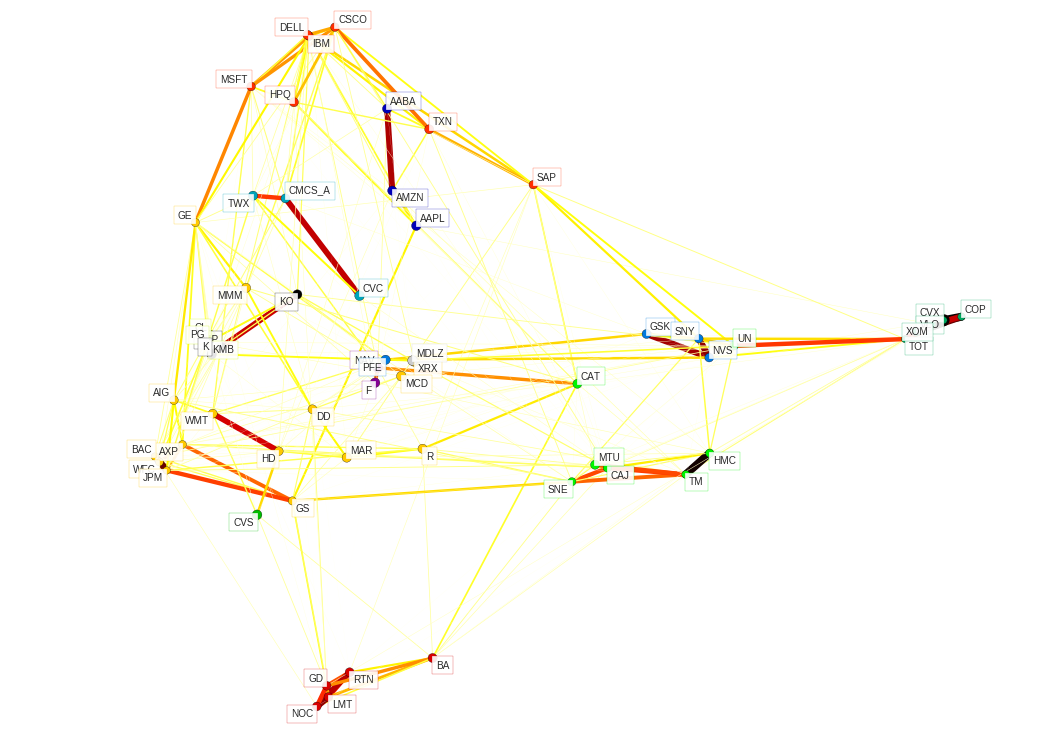

In [126]:
#Visualization

plt.figure(1, facecolor='w', figsize=(14, 10))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
#a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])

# Color normalizer
scaler = MinMaxScaler(feature_range=(0,1.5)) # I use 1.5 to stretch out range; viz looks better
scaler.fit(values)
v2=scaler.transform(values)

#plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
for i, segment in enumerate(segments):
    plt.plot((segment[0][0], segment[1][0]), (segment[0][1], segment[1][1]),zorder=0,
            color=cm.hot_r(v2[i]), linewidth=8*v2[i]);

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=cm.spectral);


for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=cm.spectral(label / float(n_labels)),
                       alpha=.9))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()